In [2]:
# pylint: disable=missing-docstring,invalid-name

# $CHALLENGIFY_BEGIN
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as ec
from selenium.webdriver.chrome.options import Options
from bs4 import BeautifulSoup
from selenium.webdriver.chrome.webdriver import WebDriver
import csv

In [4]:

# import geckodriver_autoinstaller
import chromedriver_binary


options = Options().add_argument("--headless")
options = webdriver.ChromeOptions().add_experimental_option("detach", True)

driver = webdriver.Chrome(options=options)

driver.get("https://recipes.lewagon.com/recipes/advanced")

wait = WebDriverWait(driver, 15)

search_input = driver.find_element_by_id('search_query') # Open the inspector in Chrome and find the input id!
search_input.send_keys('chocolate')
search_input.submit()

wait.until(ec.visibility_of_element_located((By.XPATH, "//div[@id='recipes']")))

recipe_urls = []
cards = driver.find_elements_by_xpath("//div[@class='recipe my-3']")
print(f"Found {len(cards)} results on the page")
for card in cards:
    url = card.get_attribute('data-href')
    recipe_urls.append(url)

print(recipe_urls)

recipes = []
for url in recipe_urls:
    print(f"Navigating to {url}")
    driver.get(url)
    wait.until(ec.visibility_of_element_located((By.XPATH, "//div[@class='p-3 border bg-white rounded-lg recipe-container']")))

    soup = BeautifulSoup(driver.page_source, 'html.parser')
    name = soup.find('h2').string.strip()
    cooktime = soup.find('span', class_='recipe-cooktime').text.strip()
    difficulty = soup.find('span', class_='recipe-difficulty').text.strip()
    price = soup.find('small', class_='recipe-price').attrs.get('data-price').strip()
    description = soup.find('p', class_='recipe-description').text.strip()
    recipes.append({
    'name': name,
    'cooktime': cooktime,
    'difficulty': difficulty,
    'price': price,
    'description': description
    })

with open('data/recipes.csv', 'w') as file:
    writer = csv.DictWriter(file, fieldnames=recipes[0].keys())
    writer.writeheader()
    writer.writerows(recipes)

driver.quit()
# $CHALLENGIFY_END

/var/folders/3y/s6r1wjkx4flbn7tcx695504c0000gn/T/ipykernel_10910/2235113382.py:14: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  search_input = driver.find_element_by_id('search_query') # Open the inspector in Chrome and find the input id!
/var/folders/3y/s6r1wjkx4flbn7tcx695504c0000gn/T/ipykernel_10910/2235113382.py:21: DeprecationWarning: find_elements_by_xpath is deprecated. Please use find_elements(by=By.XPATH, value=xpath) instead
  cards = driver.find_elements_by_xpath("//div[@class='recipe my-3']")


Found 12 results on the page
['http://recipes.lewagon.com/recipes/956/advanced', 'http://recipes.lewagon.com/recipes/748/advanced', 'http://recipes.lewagon.com/recipes/449/advanced', 'http://recipes.lewagon.com/recipes/497/advanced', 'http://recipes.lewagon.com/recipes/280/advanced', 'http://recipes.lewagon.com/recipes/992/advanced', 'http://recipes.lewagon.com/recipes/465/advanced', 'http://recipes.lewagon.com/recipes/818/advanced', 'http://recipes.lewagon.com/recipes/823/advanced', 'http://recipes.lewagon.com/recipes/873/advanced', 'http://recipes.lewagon.com/recipes/852/advanced', 'http://recipes.lewagon.com/recipes/805/advanced']
Navigating to http://recipes.lewagon.com/recipes/956/advanced
Navigating to http://recipes.lewagon.com/recipes/748/advanced
Navigating to http://recipes.lewagon.com/recipes/449/advanced
Navigating to http://recipes.lewagon.com/recipes/497/advanced
Navigating to http://recipes.lewagon.com/recipes/280/advanced
Navigating to http://recipes.lewagon.com/recipes

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.gofplots import qqplot
from statsmodels.graphics.mosaicplot import mosaic
import pandas as pd
import numpy as np

def mosaic_plot(df,X,y, ax=None):
    default_colors =plt.rcParams['axes.prop_cycle'].by_key()['color']
    cross = pd.crosstab(df[X],df[y])
    couples = cross.unstack().index
    props = lambda x: {'facecolor': default_colors[int(x[0])],'edgecolor':'w'}
    labelizer = lambda k: {(str(cpl[0]),str(cpl[1])) : f'{cpl[0]}-{cpl[1]}\n{round(cross.loc[cpl[1],cpl[0]]/cross.loc[:,cpl[0]].sum()*100,2)}%'  for cpl in couples}[k]
    mosaic(df, [y, X],properties=props,labelizer = labelizer, ax=ax)
    
def turbo_plot(df, X, y,classification):
    fig = plt.figure(constrained_layout=True,figsize=(15,round(10/3*df.shape[1])))
    subfigs = fig.subfigures(X.shape[1], 1,squeeze=False,hspace=20)

    for outerind, subfig in enumerate(subfigs.flat):
        #plotting numerical features
        if X[X.columns[outerind]].dtypes not in ['object','categorical','string'] and round(X[X.columns[outerind]].nunique()/df.shape[0]*100,2)>9:
            subfig.suptitle(f'Subfig {X.columns[outerind]}')
            axs = subfig.subplots(1, 4)
            sns.histplot(data = X, x = X.columns[outerind], kde=True, ax = axs[0])
            sns.boxplot(data = X, x = X.columns[outerind], ax = axs[1])
            qqplot(X[X.columns[outerind]],line='s',ax=axs[2])
            if classification: 
                sns.stripplot(data = X, x = y, y=X.columns[outerind], hue=y, ax = axs[3])
            else: 
                sns.scatterplot(data = X, x = X.columns[outerind], y=y, ax = axs[3])

        #plotting categorical features
        else:
            subfig.suptitle(f'Subfig {X.columns[outerind]}')
            axs = subfig.subplots(1, 4)
            sns.countplot(data = X, x = X.columns[outerind], ax = axs[0],order=X[X.columns[outerind]].value_counts().sort_values(ascending=False).index)
            if classification: 
                sns.countplot(data = X, x = X.columns[outerind], hue=y, ax = axs[1],order=X[X.columns[outerind]].value_counts().sort_values(ascending=False).index)
                mosaic_plot(df,X.columns[outerind],df.survived.name,ax=axs[2])
                sns.stripplot(data = X, x = y, y=X.columns[outerind], hue=y, ax = axs[3])
            else:
                sns.scatterplot(data = X, x = X.columns[outerind], y=y, ax = axs[3])
    return plt.show()

def quick_check(df, target:str, classification=True, to_drop=None):
    if target not in df.columns:
        raise ValueError('target not in df.columns')
    if not isinstance(target,str):
        raise TypeError('target must str')
    if to_drop:
        if all(x in df.columns for x in to_drop):
            raise ValueError('all elements in to_drop are not in df.columns')

        if not isintance(to_drop,list) and isintance(to_drop,str):
            to_drop=[to_drop]
        else:
            raise TypeError('to_drop type must be list of string')
    
    
    #Checking nan
    check= round(df.isna().sum()/df.shape[0]*100,2).sort_values(ascending=False)
    filtered = check[check>0]
    print(f'You have : {len(filtered)} features over {len(check)} ({round(check[check>0].shape[0]/check.shape[0],2)}% of whole df) that include np.nan')    

    #Features with nan
    print(f'\nHave a look at these features (% of nan): {", ".join([f"{i}: {str(v)}%" for i,v in filtered.items()])}')

    #Features to drop
    super_drop = check[check>15]
    print(f'\nYou might want to drop these features: {", ".join(super_drop.index)}')
    imputation = df[check[(check>0) & (check<15)].index].dtypes
    
    print('\n')
    print(df.info())

    print('\n')
    print("Let's have a look at all the features")
    X=df.drop(columns=(target if not to_drop else [target]+to_drop))
    y=df[target]
    turbo_plot(df, X,y,classification)

In [12]:
df = sns.load_dataset('titanic')
df.shape

(891, 15)

In [9]:
data = pd.read_csv('data_workflow.csv')
data.columns

Index(['age', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

You have : 1 features over 6 (0.17% of whole df) that include np.nan

Have a look at these features (% of nan): age: 0.3%

You might want to drop these features: 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1334 non-null   float64
 1   bmi       1338 non-null   float64
 2   children  1338 non-null   int64  
 3   smoker    1338 non-null   bool   
 4   region    1338 non-null   object 
 5   charges   1338 non-null   float64
dtypes: bool(1), float64(3), int64(1), object(1)
memory usage: 53.7+ KB
None


Let's have a look at all the features


/Users/charlesleclerc/.pyenv/versions/3.10.6/envs/lewagonos/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


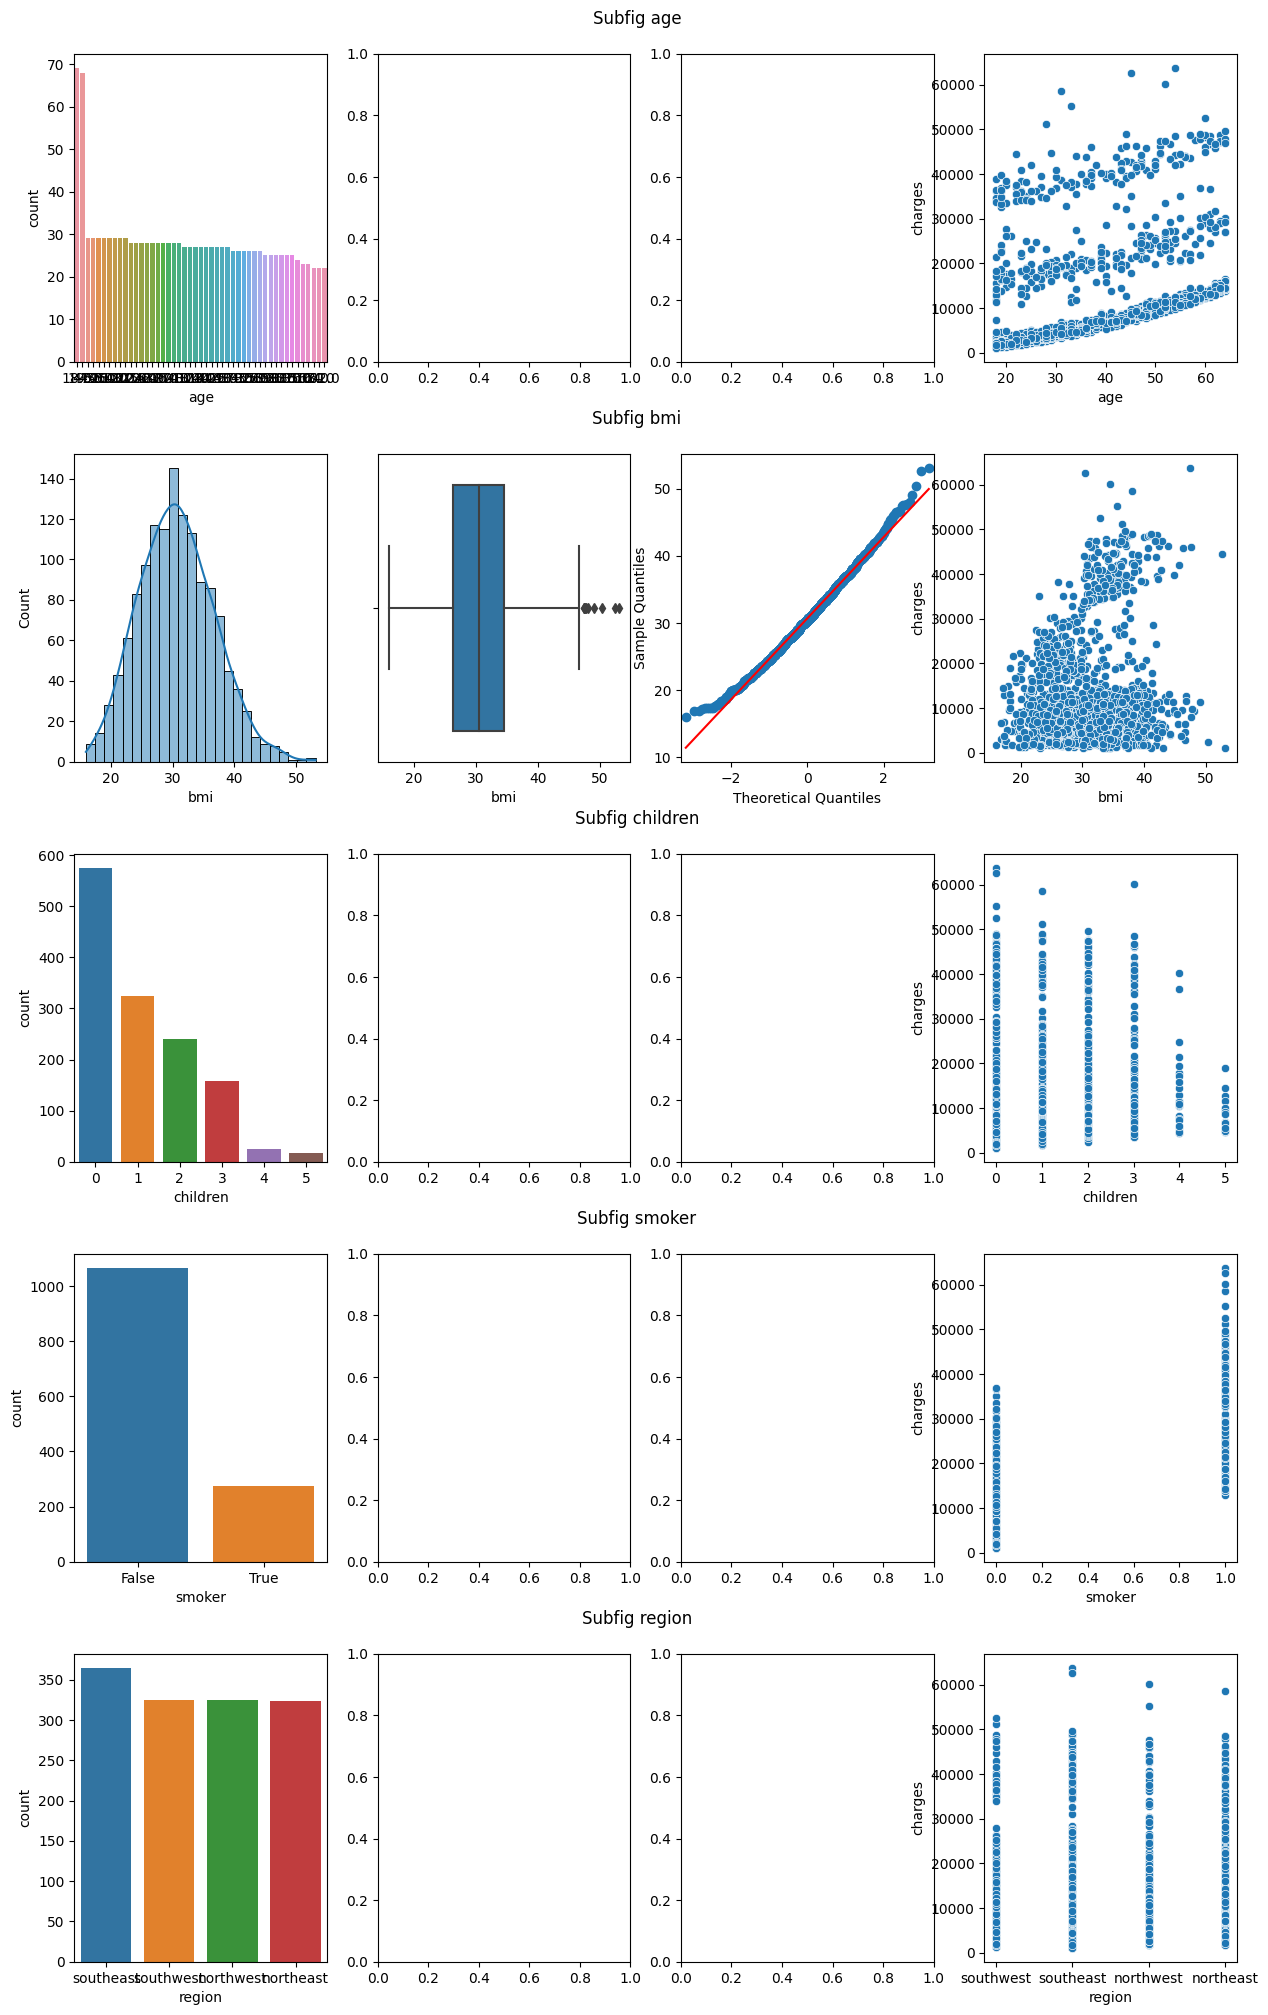

In [15]:
quick_check(data, 'charges',classification=False)

In [417]:
df.survived.name

'survived'

In [284]:
crosstable=pd.crosstab(df['survived'],df['who'])
crosstable

who,child,man,woman
survived,,,
0,34,449,66
1,49,88,205


,gender,pet
0,male,cat
1,male,dog
2,male,dog
3,female,cat
4,female,dog
5,female,cat


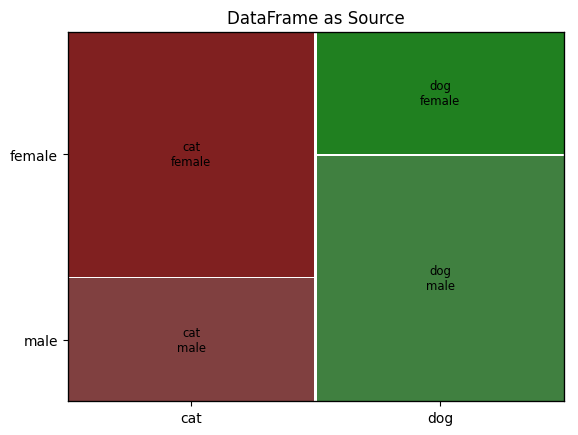

In [291]:
gender = ['male', 'male', 'male', 'female', 'female', 'female']
pet = ['cat', 'dog', 'dog', 'cat', 'dog', 'cat']
data = pd.DataFrame({'gender': gender, 'pet': pet})
mosaic(data, ['pet', 'gender'], title='DataFrame as Source')
data

In [327]:
couleurs = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [335]:
toto = list(df[['survived','class']].groupby(['survived','class']).size().index)
props = {couple : {'facecolor':couleurs[couple[0]], 'edgecolor':'white'} for couple in toto}

In [336]:
props

{(0, 'First'): {'facecolor': '#1f77b4', 'edgecolor': 'white'},
 (0, 'Second'): {'facecolor': '#1f77b4', 'edgecolor': 'white'},
 (0, 'Third'): {'facecolor': '#1f77b4', 'edgecolor': 'white'},
 (1, 'First'): {'facecolor': '#ff7f0e', 'edgecolor': 'white'},
 (1, 'Second'): {'facecolor': '#ff7f0e', 'edgecolor': 'white'},
 (1, 'Third'): {'facecolor': '#ff7f0e', 'edgecolor': 'white'}}

In [366]:
toto = list(df[['survived','class']].groupby(['survived','class']).size().index)
toto

[(0, 'First'),
 (0, 'Second'),
 (0, 'Third'),
 (1, 'First'),
 (1, 'Second'),
 (1, 'Third')]

In [385]:
cross = pd.crosstab(df['survived'],df['class'])

80

In [524]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.mosaicplot import mosaic

def mosaic_plot(df,X,y, ax=None):
    default_colors =plt.rcParams['axes.prop_cycle'].by_key()['color']
    cross = pd.crosstab(df[X],df[y])
    couples = cross.unstack().index
    props = lambda x: {'facecolor': default_colors[int(x[0])],'edgecolor':'w'}
    labelizer = lambda k: {(str(cpl[0]),str(cpl[1])) : f'{cpl[0]}-{cpl[1]}\n{round(cross.loc[cpl[1],cpl[0]]/cross.loc[:,cpl[0]].sum()*100,2)}%'  for cpl in couples}[k]
    mosaic(df, [y, X],properties=props,labelizer = labelizer, ax=ax)

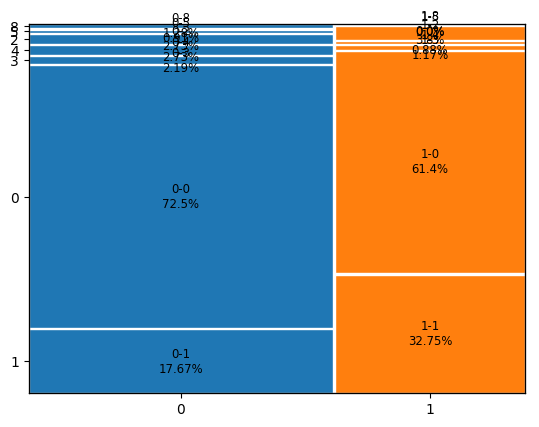

In [525]:
mosaic_plot(df,'sibsp','survived')

In [431]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.mosaicplot import mosaic

def mosaic_plot(df,X,y, ax=None):
    default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    couples = list(df[[y,X]].groupby([y,X]).size().astype(str).index)
    cross = pd.crosstab(df[y],df[X])
    props = lambda x: {'facecolor': default_colors[int(x[0])],'edgecolor':'w'}
    labelizer = lambda k: {(str(couple[0]),str(couple[1])) : f'{couple[0]}-{couple[1]}\n{round(cross.loc[couple[0],couple[1]]/cross.loc[couple[0]].sum()*100,2)}%'  for couple in toto}[k]
    mosaic(df, [y, X],properties=props2,labelizer = labelizer, ax=ax)

In [426]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.mosaicplot import mosaic

def mosaic_plot(df,X,y,ax=None):
    default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    couples = list(df[['survived','class']].groupby(['survived','class']).size().astype(str).index)
    cross = pd.crosstab(df['survived'],df['class'])
    props = lambda x: {'facecolor': default_colors[int(x[0])],'edgecolor':'w'}
    labelizer = lambda k: {(str(couple[0]),str(couple[1])) : f'{couple[0]}-{couple[1]}\n{round(cross.loc[couple[0],couple[1]]/cross.loc[couple[0]].sum()*100,2)}%'  for couple in toto}[k]
    mosaic(df, ['survived', 'class'],properties=props2,labelizer = labelizer, ax=ax)

In [ ]:
quick_check(df,'survived',classification=True)

In [95]:
dataframe = df.select_dtypes(exclude=['category','object','string'])
dataframe

,survived,pclass,age,sibsp,parch,fare,adult_male,alone
0,0,3,22.0,1,0,7.2500,True,False
1,1,1,38.0,1,0,71.2833,False,False
2,1,3,26.0,0,0,7.9250,False,True
3,1,1,35.0,1,0,53.1000,False,False
4,0,3,35.0,0,0,8.0500,True,True
...,...,...,...,...,...,...,...,...
886,0,2,27.0,0,0,13.0000,True,True
887,1,1,19.0,0,0,30.0000,False,True
888,0,3,NaN,1,2,23.4500,False,False
889,1,1,26.0,0,0,30.0000,True,True


In [33]:
df

0.2783389450056117

survived          int64
pclass            int64
sex              object
age             float64
sibsp             int64
parch             int64
fare            float64
embarked         object
class          category
who              object
adult_male         bool
deck           category
embark_town      object
alive            object
alone              bool
dtype: object

In [12]:
X = df.drop(columns = 'survived')
y = df.survived

/Users/charlesleclerc/.pyenv/versions/3.10.6/envs/lewagonos/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


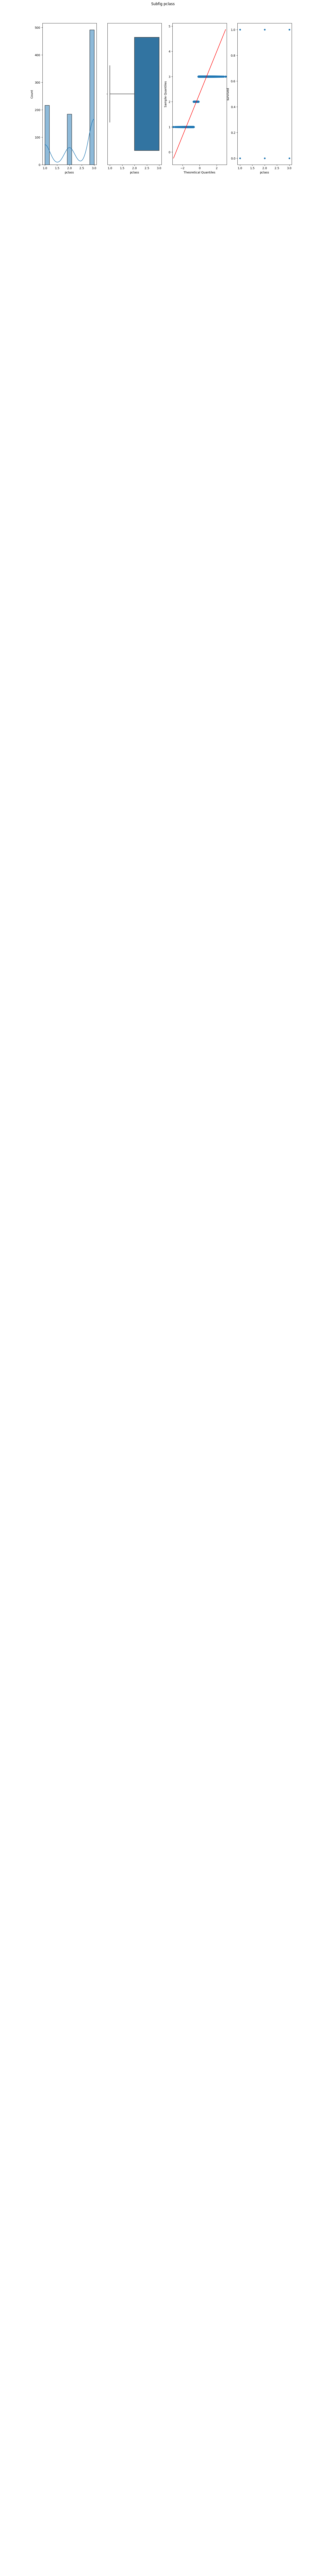

In [13]:
turbo_plot(X,y)

In [3]:
default_colors

NameError: name 'default_colors' is not defined

In [2]:
import pySankey

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.mosaicplot import mosaic

def mosaic_plot(df,X,y,ax=None):
    default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    couples = list(df[['survived','class']].groupby(['survived','class']).size().astype(str).index)
    cross = pd.crosstab(df['survived'],df['class'])
    props = lambda x: {'facecolor': default_colors[int(x[0])],'edgecolor':'w'}
    labelizer = lambda k: {(str(couple[0]),str(couple[1])) : f'{couple[0]}-{couple[1]}\n{round(cross.loc[couple[0],couple[1]]/cross.loc[couple[0]].sum()*100,2)}%'  for couple in toto}[k]
    mosaic(df, ['survived', 'class'],properties=props2,labelizer = labelizer, ax=ax)

In [594]:
df[['pclass','survived']]

,pclass,survived
0,3,0
1,1,1
2,3,1
3,1,1
...,...,...
887,1,1
888,3,0
889,1,1
890,3,0


In [24]:
import pandas as pd
from pySankey.sankey import sankey

sankey(df['survived'], df['pclass'], aspect=20,fontsize=12)
# Result is in "fruit.png"

In [3]:
from collections import defaultdict

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


def check_data_matches_labels(labels, data, side):
    if len(labels > 0):
        if isinstance(data, list):
            data = set(data)
        if isinstance(data, pd.Series):
            data = set(data.unique().tolist())
        if isinstance(labels, list):
            labels = set(labels)
        if labels != data:
            msg = "\n"
            if len(labels) <= 20:
                msg = "Labels: " + ",".join(labels) + "\n"
            if len(data) < 20:
                msg += "Data: " + ",".join(data)
            raise LabelMismatch('{0} labels and data do not match.{1}'.format(side, msg))


def dankey(left, right, leftWeight=None, rightWeight=None, colorDict=None,
           leftLabels=None, rightLabels=None, aspect=4, rightColor=False,
           fontsize=14, figureName=None, closePlot=False,ax=None):
    '''
    Make Sankey Diagram showing flow from left-->right
    Inputs:
        left = NumPy array of object labels on the left of the diagram
        right = NumPy array of corresponding labels on the right of the diagram
            len(right) == len(left)
        leftWeight = NumPy array of weights for each strip starting from the
            left of the diagram, if not specified 1 is assigned
        rightWeight = NumPy array of weights for each strip starting from the
            right of the diagram, if not specified the corresponding leftWeight
            is assigned
        colorDict = Dictionary of colors to use for each label
            {'label':'color'}
        leftLabels = order of the left labels in the diagram
        rightLabels = order of the right labels in the diagram
        aspect = vertical extent of the diagram in units of horizontal extent
        rightColor = If true, each strip in the diagram will be be colored
                    according to its left label
    Ouput:
        None
    '''
    if leftWeight is None:
        leftWeight = []
    if rightWeight is None:
        rightWeight = []
    if leftLabels is None:
        leftLabels = []
    if rightLabels is None:
        rightLabels = []
    # Check weights
    if len(leftWeight) == 0:
        leftWeight = np.ones(len(left))

    if len(rightWeight) == 0:
        rightWeight = leftWeight

    plt.figure()
    plt.rc('text', usetex=False)
    plt.rc('font', family='serif')

    # Create Dataframe
    if isinstance(left, pd.Series):
        left = left.reset_index(drop=True)
    if isinstance(right, pd.Series):
        right = right.reset_index(drop=True)
    dataFrame = pd.DataFrame({'left': left, 'right': right, 'leftWeight': leftWeight,
                              'rightWeight': rightWeight}, index=range(len(left)))

    if len(dataFrame[(dataFrame.left.isnull()) | (dataFrame.right.isnull())]):
        raise NullsInFrame('Sankey graph does not support null values.')

    # Identify all labels that appear 'left' or 'right'
    allLabels = pd.Series(np.r_[dataFrame.left.unique(), dataFrame.right.unique()]).unique()

    # Identify left labels
    if len(leftLabels) == 0:
        leftLabels = pd.Series(dataFrame.left.unique()).unique()
    else:
        check_data_matches_labels(leftLabels, dataFrame['left'], 'left')

    # Identify right labels
    if len(rightLabels) == 0:
        rightLabels = pd.Series(dataFrame.right.unique()).unique()
    else:
        check_data_matches_labels(leftLabels, dataFrame['right'], 'right')
    # If no colorDict given, make one
    if colorDict is None:
        colorDict = {}
        palette = "hls"
        colorPalette = sns.color_palette(palette, len(allLabels))
        for i, label in enumerate(allLabels):
            colorDict[label] = colorPalette[i]
    else:
        missing = [label for label in allLabels if label not in colorDict.keys()]
        if missing:
            msg = "The colorDict parameter is missing values for the following labels : "
            msg += '{}'.format(', '.join(missing))
            raise ValueError(msg)

    # Determine widths of individual strips
    ns_l = defaultdict()
    ns_r = defaultdict()
    for leftLabel in leftLabels:
        leftDict = {}
        rightDict = {}
        for rightLabel in rightLabels:
            leftDict[rightLabel] = dataFrame[(dataFrame.left == leftLabel) & (dataFrame.right == rightLabel)].leftWeight.sum()
            rightDict[rightLabel] = dataFrame[(dataFrame.left == leftLabel) & (dataFrame.right == rightLabel)].rightWeight.sum()
        ns_l[leftLabel] = leftDict
        ns_r[leftLabel] = rightDict

    # Determine positions of left label patches and total widths
    leftWidths = defaultdict()
    for i, leftLabel in enumerate(leftLabels):
        myD = {}
        myD['left'] = dataFrame[dataFrame.left == leftLabel].leftWeight.sum()
        if i == 0:
            myD['bottom'] = 0
            myD['top'] = myD['left']
        else:
            myD['bottom'] = leftWidths[leftLabels[i - 1]]['top'] + 0.02 * dataFrame.leftWeight.sum()
            myD['top'] = myD['bottom'] + myD['left']
            topEdge = myD['top']
        leftWidths[leftLabel] = myD

    # Determine positions of right label patches and total widths
    rightWidths = defaultdict()
    for i, rightLabel in enumerate(rightLabels):
        myD = {}
        myD['right'] = dataFrame[dataFrame.right == rightLabel].rightWeight.sum()
        if i == 0:
            myD['bottom'] = 0
            myD['top'] = myD['right']
        else:
            myD['bottom'] = rightWidths[rightLabels[i - 1]]['top'] + 0.02 * dataFrame.rightWeight.sum()
            myD['top'] = myD['bottom'] + myD['right']
            topEdge = myD['top']
        rightWidths[rightLabel] = myD

    # Total vertical extent of diagram
    xMax = topEdge / aspect

    # Draw vertical bars on left and right of each  label's section & print label
    for leftLabel in leftLabels:
        plt.fill_between(
            [-0.02 * xMax, 0],
            2 * [leftWidths[leftLabel]['bottom']],
            2 * [leftWidths[leftLabel]['bottom'] + leftWidths[leftLabel]['left']],
            color=colorDict[leftLabel],
            alpha=0.99
        )
        plt.text(
            -0.05 * xMax,
            leftWidths[leftLabel]['bottom'] + 0.5 * leftWidths[leftLabel]['left'],
            leftLabel,
            {'ha': 'right', 'va': 'center'},
            fontsize=fontsize
        )
    for rightLabel in rightLabels:
        plt.fill_between(
            [xMax, 1.02 * xMax], 2 * [rightWidths[rightLabel]['bottom']],
            2 * [rightWidths[rightLabel]['bottom'] + rightWidths[rightLabel]['right']],
            color=colorDict[rightLabel],
            alpha=0.99
        )
        plt.text(
            1.05 * xMax,
            rightWidths[rightLabel]['bottom'] + 0.5 * rightWidths[rightLabel]['right'],
            rightLabel,
            {'ha': 'left', 'va': 'center'},
            fontsize=fontsize
        )

    # Plot strips
    for leftLabel in leftLabels:
        for rightLabel in rightLabels:
            labelColor = leftLabel
            if rightColor:
                labelColor = rightLabel
            if len(dataFrame[(dataFrame.left == leftLabel) & (dataFrame.right == rightLabel)]) > 0:
                # Create array of y values for each strip, half at left value,
                # half at right, convolve
                ys_d = np.array(50 * [leftWidths[leftLabel]['bottom']] + 50 * [rightWidths[rightLabel]['bottom']])
                ys_d = np.convolve(ys_d, 0.05 * np.ones(20), mode='valid')
                ys_d = np.convolve(ys_d, 0.05 * np.ones(20), mode='valid')
                ys_u = np.array(50 * [leftWidths[leftLabel]['bottom'] + ns_l[leftLabel][rightLabel]] + 50 * [rightWidths[rightLabel]['bottom'] + ns_r[leftLabel][rightLabel]])
                ys_u = np.convolve(ys_u, 0.05 * np.ones(20), mode='valid')
                ys_u = np.convolve(ys_u, 0.05 * np.ones(20), mode='valid')

                # Update bottom edges at each label so next strip starts at the right place
                leftWidths[leftLabel]['bottom'] += ns_l[leftLabel][rightLabel]
                rightWidths[rightLabel]['bottom'] += ns_r[leftLabel][rightLabel]
                plt.fill_between(
                    np.linspace(0, xMax, len(ys_d)), ys_d, ys_u, alpha=0.65,
                    color=colorDict[labelColor]
                )
    plt.gca().axis('off')
    plt.gcf().set_size_inches(6, 6)
    if figureName != None:
        plt.savefig("{}.png".format(figureName), bbox_inches='tight', dpi=150)
    if closePlot:
        plt.close()
    plt.show()

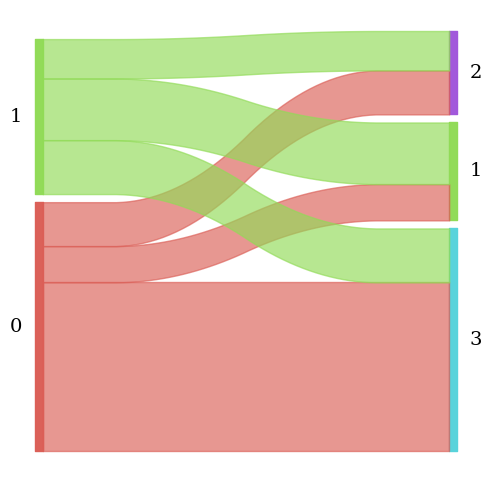

In [4]:
dankey(df['survived'], df['pclass'])